In [3]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import math
import random

import scipy.stats as stats

from scipy.stats import fit
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import fisher_exact
from scipy.stats import zscore
from scipy.stats import percentileofscore
from statsmodels.stats.multitest import multipletests # for fdr
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import wilcoxon





In [5]:
%%R

library(dplyr)
library(ggplot2)
library(readr)
library(stringr)
library(scales)
library(data.table)
library(grid)
library(ggsignif)


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘scales’


R[write to console]: The following object is masked from ‘package:readr’:

    col_factor


R[write to console]: data.table 1.17.0 usando 5 hilos (ver ?getDTthreads).  
R[write to console]: Últimas novedades: r-datatable.com

R[write to console]: **********
Ejecutando data.table en Español. El soporte del paquete está disponible solo en inglés. Cuando busque ayuda en línea, asegúrese de comprobar también el mensaje de error en inglés, examinando los archivos po/R-<locale>.po y po/<locale>.po en el código fuente del paquete. Allí se encuentran los mensajes de error en el idioma nativo y en inglés uno al lado del otro. You can also try calling Sys.setLanguage('en') prior to rep

Enrichment lollypop plot

In [6]:
%%R
human     <- fread("../Data/Human_nuno_plot_data.tsv")
rhesus    <- fread("../Data/rhesus_plot_data_new.tsv")
chimp     <- fread("../Data/Chimp_plot_data.tsv")
orangutan <- fread("../Data/orangutan_plot_data.tsv")


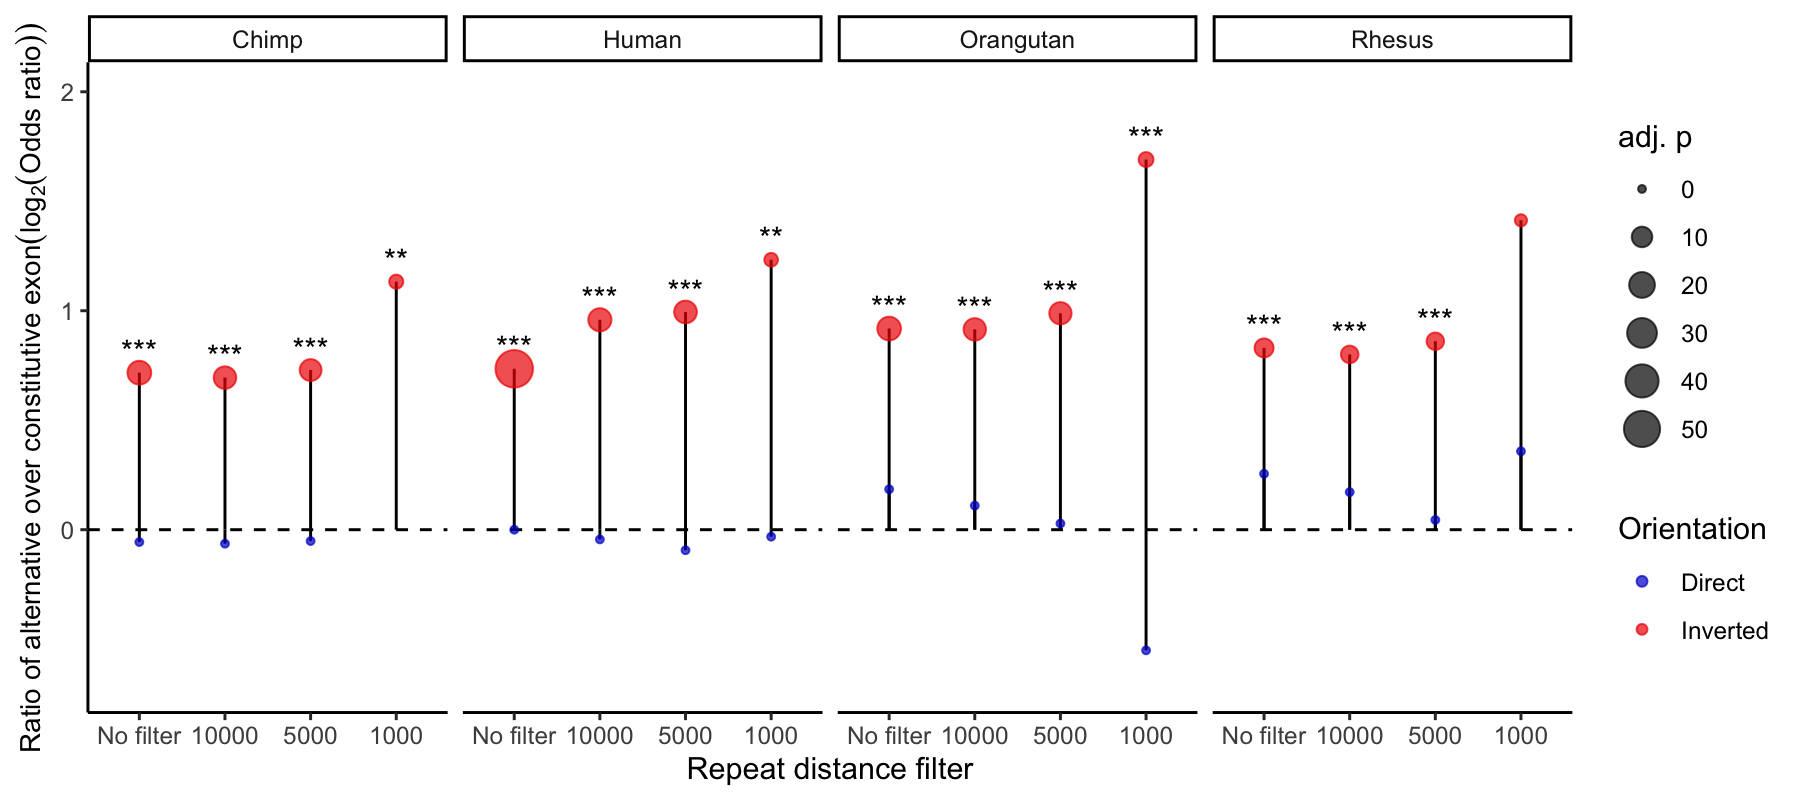

In [7]:
%%R -w 9 -h 4 --units in -r 200

# 2. Add a 'species' column to each dataset
human[, species := "Human"]
rhesus[, species := "Rhesus"]
chimp[, species := "Chimp"]
orangutan[, species := "Orangutan"]

# 3. Combine all data into one data.table
all_data <- rbind(human, rhesus, chimp, orangutan, fill = TRUE)

# 4. Compute Bonferroni-adjusted p-values (assuming each dataset has a column 'P_Value')
all_data[, adj_p_val := p.adjust(P_Value, method = "bonferroni")]

# 5. Create significance labels based on adj_p_val
all_data[, significance := cut(adj_p_val,
                                 breaks = c(0, 0.001, 0.01, 0.05, 1),
                                 labels = c("***", "**", "*", "ns"))]

# 6. Ensure Dist_threshold is a factor with the desired order
all_data[, Dist_threshold := factor(Dist_threshold,
                                     levels = c("No filter", "10000", "5000", "1000"))]

# 7. Create the plot with facet_wrap to display all species side by side
multi_species_plot <- ggplot(all_data, aes(x = Dist_threshold, y = log2(Odds_Ratio))) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
  geom_segment(aes(x = Dist_threshold, xend = Dist_threshold, 
                   y = 0, yend = log2(Odds_Ratio)),
               color = "black", size = 0.5) +
  geom_point(aes(colour = Type, size = -log10(adj_p_val)), alpha = 0.7) +
  geom_text(data = subset(all_data, significance != "ns"),
            aes(label = significance),
            vjust = -0.5) +
  facet_wrap(~ species, nrow = 1) +
  xlab("Repeat distance filter") +
  ylab(expression("Ratio of alternative over constitutive exon" * (log[2]("Odds ratio")))) +
  ylim(c(-0.7, 2)) +
  scale_colour_manual(name = "Orientation",
                      values = c("Direct" = "blue3", "Inverted" = "red2")) +
  scale_size_continuous(name = "adj. p") +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5),
        axis.title.y = element_text(size = 10))

print(multi_species_plot)


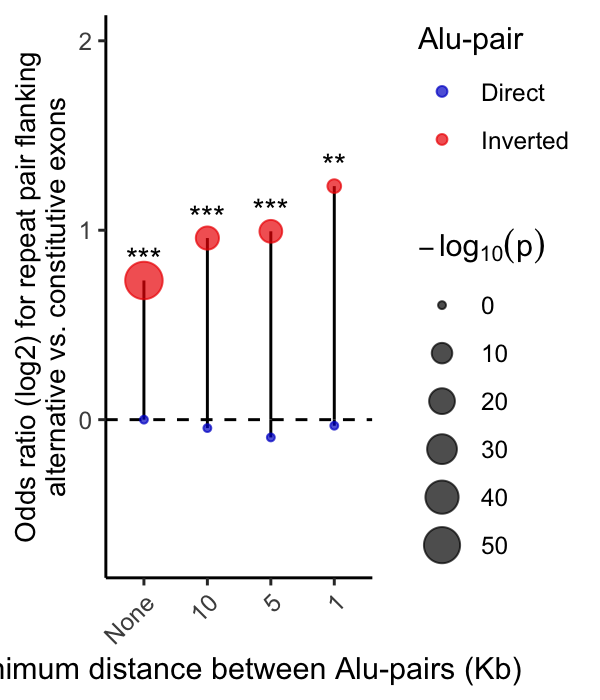

In [83]:
%%R -w 3 -h 3.5 --units in -r 200

#Figure 1B

fig1B <- ggplot(all_data[species == "Human"], aes(x = Dist_threshold, y = log2(Odds_Ratio))) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
  geom_segment(aes(x = Dist_threshold, xend = Dist_threshold, 
                   y = 0, yend = log2(Odds_Ratio)),
               color = "black", size = 0.5) +
  geom_point(aes(colour = Type, size = -log10(adj_p_val)), alpha = 0.7) +
  geom_text(data = subset(all_data[species == "Human"], significance != "ns"),
            aes(label = significance),
            vjust = -0.5) +
  xlab("Minimum distance between Alu-pairs (Kb)") +
  ylab("Odds ratio (log2) for repeat pair flanking\nalternative vs. constitutive exons") +
  ylim(c(-0.7, 2)) +
  scale_x_discrete(labels = c("No filter" = "None",
                              "10000" = "10",
                              "5000"  = "5",
                              "1000"  = "1")) +
  scale_colour_manual(name = "Alu-pair",
                      values = c("Direct" = "blue3", "Inverted" = "red2")) +
  scale_size_continuous(name = expression(-log[10](p))) +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5),
        axis.title.y = element_text(size = 10), axis.text.x = element_text(angle = 45, hjust=1))

print(fig1B)


# SPLASH results

In [9]:
%%R

Fig1E_repeat_types <- fread("../Data//Fig2_Alu_pair_types.txt")



	Fisher's Exact Test for Count Data

data:  contingency_table
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.02757881 0.08863761
sample estimates:
odds ratio 
0.05146059 



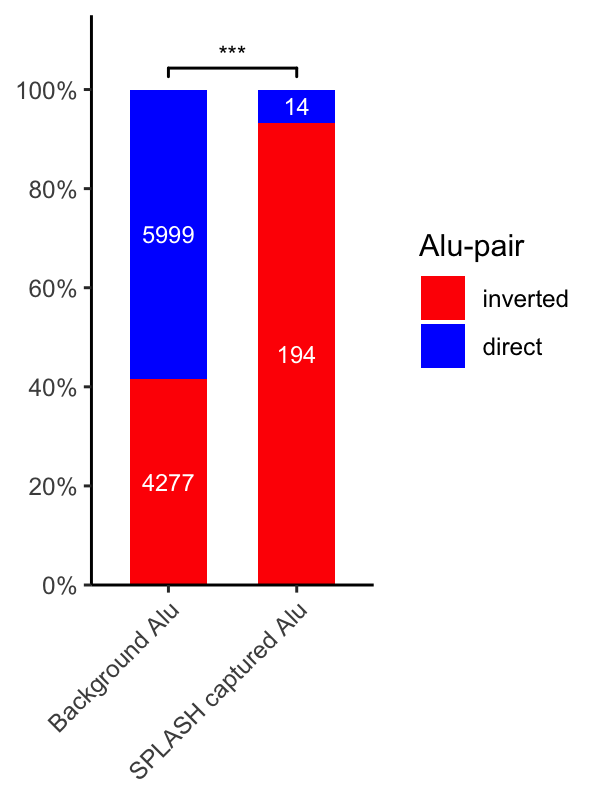

In [74]:
%%R -w 3 -h 4 --units in -r 200

#Fig1E

Fig1E_repeat_types[, orientation := type_meta]

# Assign the data to data_sub.
data_sub <- Fig1E_repeat_types

# (Re)calculate totals and percentages if needed.
data_sub[, total := sum(count), by = group]
data_sub[, perc := count / total]

contingency_table <- matrix(
  c(4277, 5999,   # Background_Alu: [inverted, direct]
    194,  14),    # SPLASH_captured_Alu: [inverted, direct]
  nrow = 2, byrow = TRUE
)
rownames(contingency_table) <- c("Background_Alu", "SPLASH_captured_Alu")
colnames(contingency_table) <- c("inverted", "direct")
fisher_result <- fisher.test(contingency_table)
p_value <- fisher_result$p.value
sig_label <- ifelse(p_value < 0.001, "***",
              ifelse(p_value < 0.01, "**",
              ifelse(p_value < 0.05, "*", "ns")))

print(fisher_result)

# Prepare a data frame of totals for annotation.
totals <- unique(data_sub[, .(group, total)])



Fig1E <- ggplot(data_sub, aes(x = group, y = perc, fill = orientation)) +
  geom_bar(stat = "identity", position = "fill", width = 0.6) +

  scale_fill_manual(
    name = "Alu-pair",
    values = c("inverted" = "red", "direct"  = "blue")
  ) +

  # new: show raw counts inside each bar segment
  geom_text(aes(label = count),
            position = position_fill(vjust = 0.5),
            color = "white", size = 3) +

  # (totals annotation removed!)

  scale_x_discrete(labels = c(
    "SPLASH_captured_Alu"  = "SPLASH captured Alu",
    "Background_Alu"       = "Background Alu"
  )) +
  theme_classic() +
  theme(
    axis.title.x    = element_blank(),
    axis.title.y    = element_blank(),
    axis.text.x     = element_text(angle = 45, hjust = 1),
    legend.position = "right",
    legend.direction= "vertical"
  ) +
  guides(fill = guide_legend(reverse = TRUE)) +

  geom_signif(
    comparisons = list(c("Background_Alu", "SPLASH_captured_Alu")),
    annotations = sig_label,
    y_position  = 1.0,
    tip_length  = 0.02,
    textsize    = 3
  ) +

  scale_y_continuous(
    breaks  = seq(0, 1, by = 0.2),
    labels  = scales::percent_format(accuracy = 1),
    expand  = c(0, 0),
    limits  = c(0, 1.15)
  )

print(Fig1E)


In [11]:

alu_meta_ext = pd.read_csv("../Data/alu_meta_ext.txt", sep = "\t")


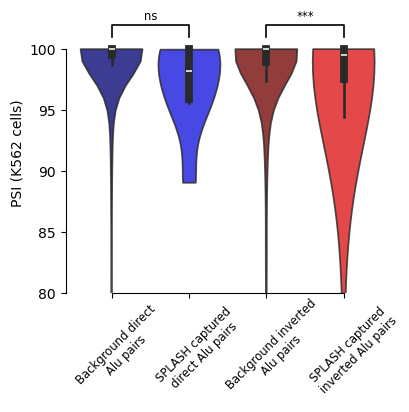

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- 1. build the four series ---
bg_direct = (
    alu_meta_ext
    .loc[
        (alu_meta_ext["type_meta"] == "Alu_pair") &
        (alu_meta_ext["pair_type"] == "direct"),
        "PSI_K562"
    ]
    .dropna()
    .reset_index(drop=True)
)
sp_direct = (
    alu_meta_ext
    .loc[
        (alu_meta_ext["type_meta"] == "Alu_pair") &
        (alu_meta_ext["pair_type"] == "direct") &
        (alu_meta_ext["total_counts"] > 0),
        "PSI_K562"
    ]
    .dropna()
    .reset_index(drop=True)
)
bg_inverted = (
    alu_meta_ext
    .loc[
        (alu_meta_ext["type_meta"] == "Alu_pair") &
        (alu_meta_ext["pair_type"] == "inverted"),
        "PSI_K562"
    ]
    .dropna()
    .reset_index(drop=True)
)
sp_inverted = (
    alu_meta_ext
    .loc[
        (alu_meta_ext["type_meta"] == "Alu_pair") &
        (alu_meta_ext["pair_type"] == "inverted") &
        (alu_meta_ext["total_counts"] > 0),
        "PSI_K562"
    ]
    .dropna()
    .reset_index(drop=True)
)

df = pd.concat([bg_direct, sp_direct, bg_inverted, sp_inverted], axis=1)
df.columns = [
    "Background direct\nAlu pairs",
    "SPLASH captured\ndirect Alu pairs",
    "Background inverted\nAlu pairs",
    "SPLASH captured\ninverted Alu pairs"
]

# --- 2. compute KS p‑values ---
p_direct   = stats.ks_2samp(bg_direct,   sp_direct)[1]
p_inverted = stats.ks_2samp(bg_inverted, sp_inverted)[1]

def signif_label(p):
    if p <= 0.001:
        return "***"
    elif p <= 0.01:
        return "**"
    elif p <= 0.05:
        return "*"
    else:
        return "ns"

star_direct   = signif_label(p_direct)
star_inverted = signif_label(p_inverted)

# --- 3. plot ---
label_pad = 30

fig, ax = plt.subplots(figsize=(4, 4))
sns.violinplot(
    data=df,
    order=df.columns,
    inner="box",
    cut=0,
    alpha=0.82,                   # <-- make violins semi-transparent
    palette=[
        "#00008B",  # dark blue
        "#0000FF",  # bright blue
        "#8B0000",  # dark red
        "#FF0000",  # bright red
    ],
    ax=ax
)

ax.set_ylabel("PSI (K562 cells)")
ax.set_xlabel("")
max_dat = df.max().max()
ax.set_ylim(80, max_dat + 3)
ax.set_yticks([80, 85, 90, 95, 100])
sns.despine(trim=True)

ax.set_xticklabels(
    df.columns,
    rotation=45,
    ha="center",
    rotation_mode="anchor",
    fontsize="small"
)
ax.tick_params(axis="x", pad=label_pad)

# --- 4. significance bars ---
y0, y1 = max_dat + 1, max_dat + 2

ax.plot([0, 0, 1, 1], [y0, y1, y1, y0], lw=1.2, c="k")
ax.text(0.5, y1 + 0.2, star_direct, ha="center", va="bottom", fontsize="small")

ax.plot([2, 2, 3, 3], [y0, y1, y1, y0], lw=1.2, c="k")
ax.text(2.5, y1 + 0.2, star_inverted, ha="center", va="bottom", fontsize="small")

plt.tight_layout(pad=0.3)
plt.show()

fig.savefig("../Figures/Fig_1F.png", dpi=300, bbox_inches="tight")

In [13]:
%%R

library(cowplot)
library(png)


In [14]:
%%R


fig1A_img <- readPNG("../Figures/Fig_1A.PNG")
fig1C_img <- readPNG("../Figures/Fig_1C.PNG")
fig1D_img <- readPNG("../Figures/Fig_1D.PNG")
fig1F_img <- readPNG("../Figures/Fig_1F.png")

fig1A<- rasterGrob(fig1A_img, interpolate = TRUE)
fig1C <- rasterGrob(fig1C_img, interpolate = TRUE)
fig1D <- rasterGrob(fig1D_img, interpolate = TRUE)
fig1F<- rasterGrob(fig1F_img, interpolate = TRUE)


blank_plot <- ggplot() + theme_void()




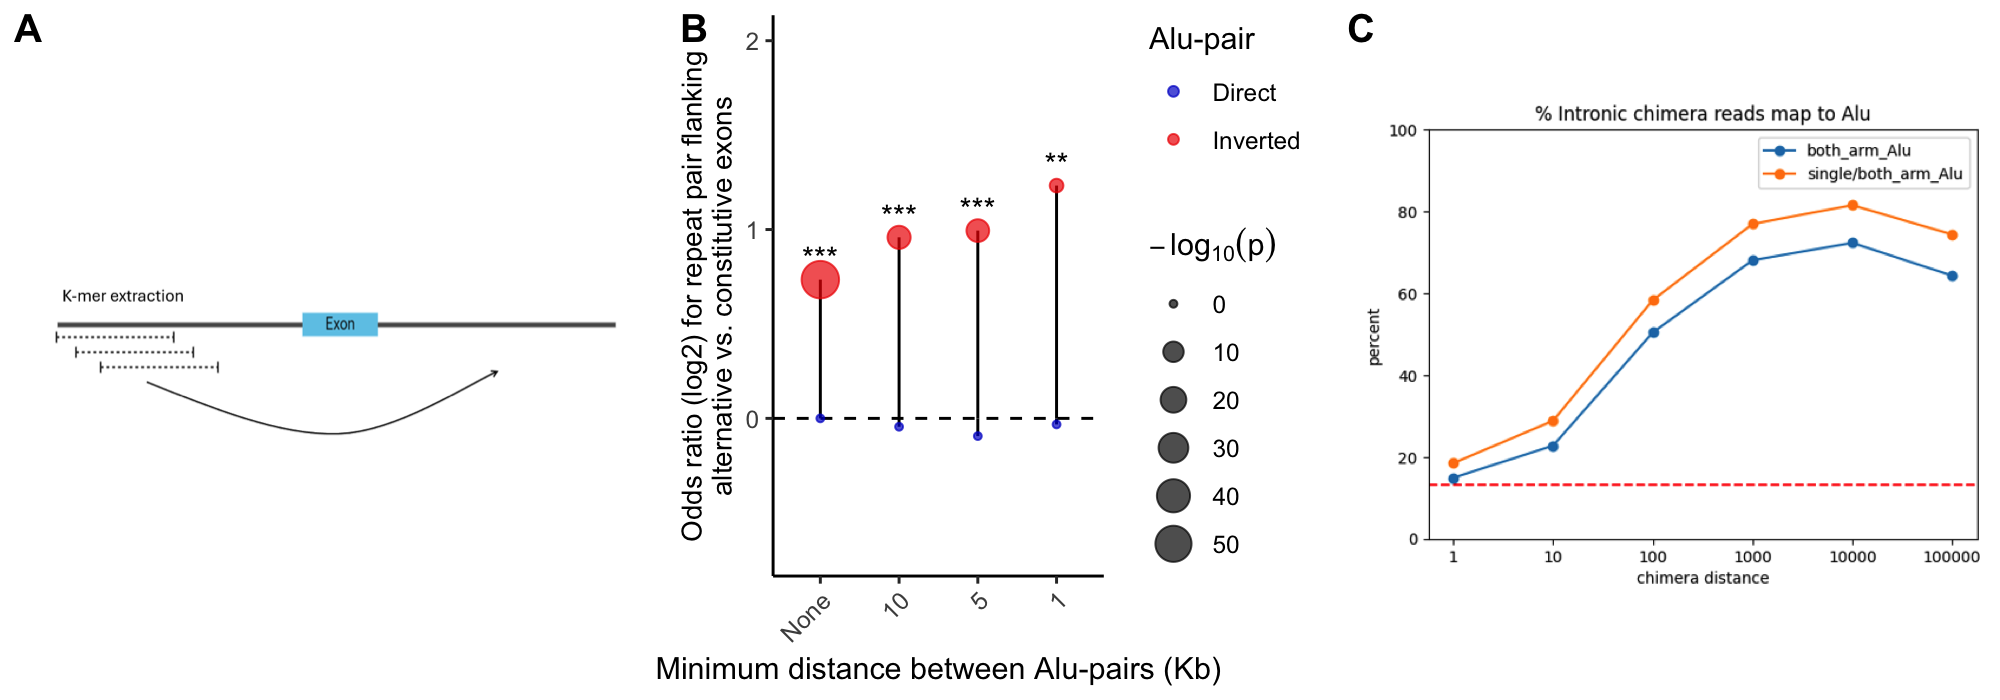

In [84]:
%%R -w 10 -h 3.5 --units in -r 200


top_row <- plot_grid(
  fig1A, 
  fig1B, 
  fig1C,
  labels = "AUTO",
  nrow = 1,
  rel_widths = c(1, 1, 1))

top_row


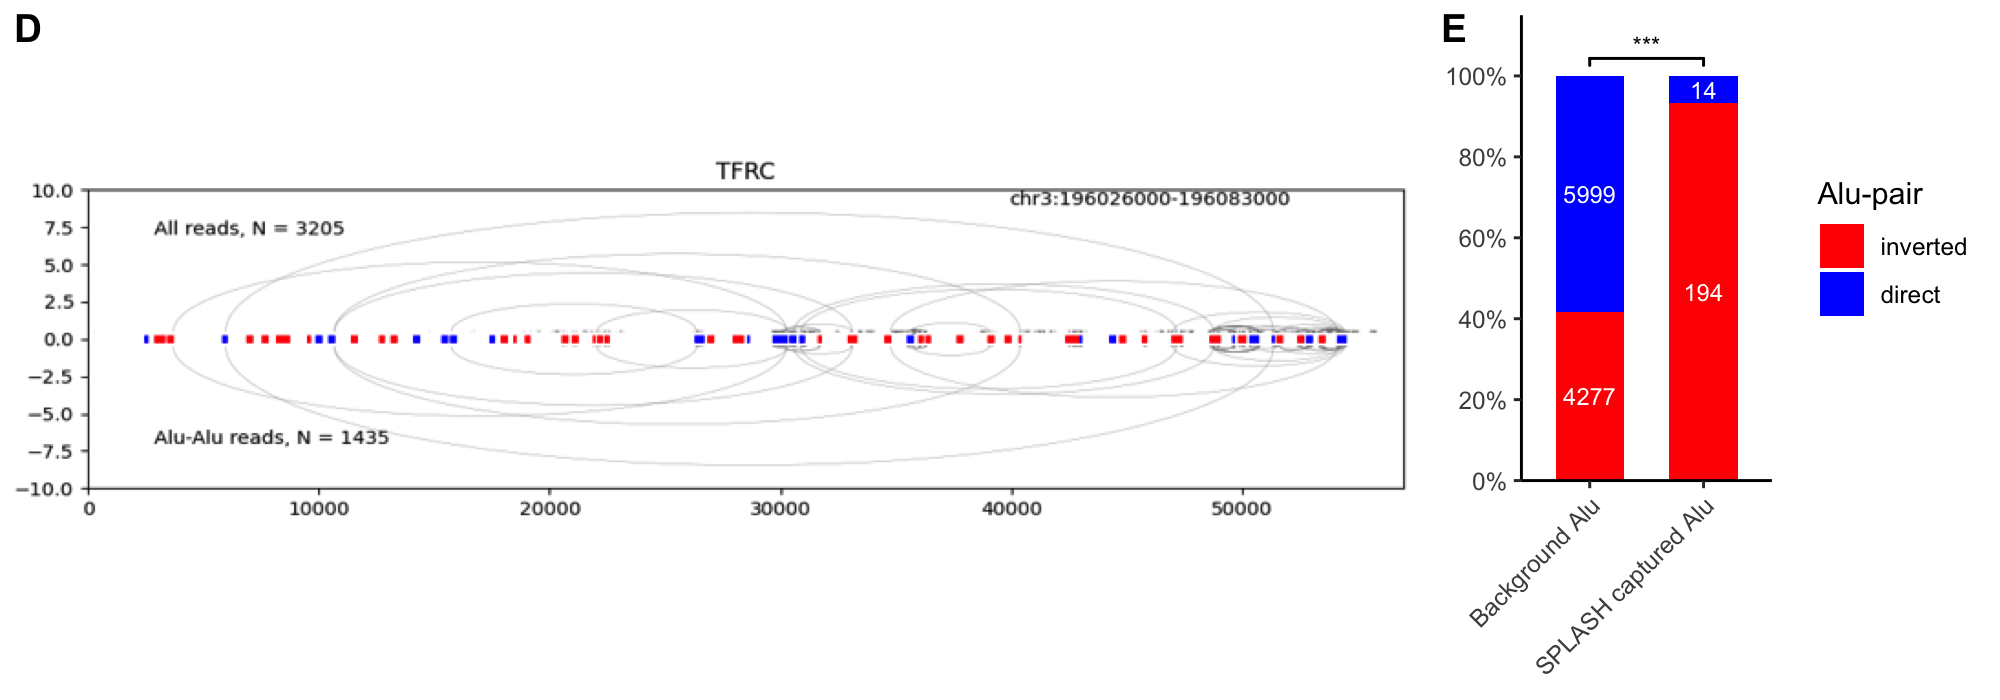

In [77]:
%%R -w 10 -h 3.5 --units in -r 200


middle_row <- plot_grid(
  fig1D, 
  Fig1E, 
  nrow = 1, 
  labels = c("D", "E"),
  rel_widths = c(2.5, 1))


middle_row

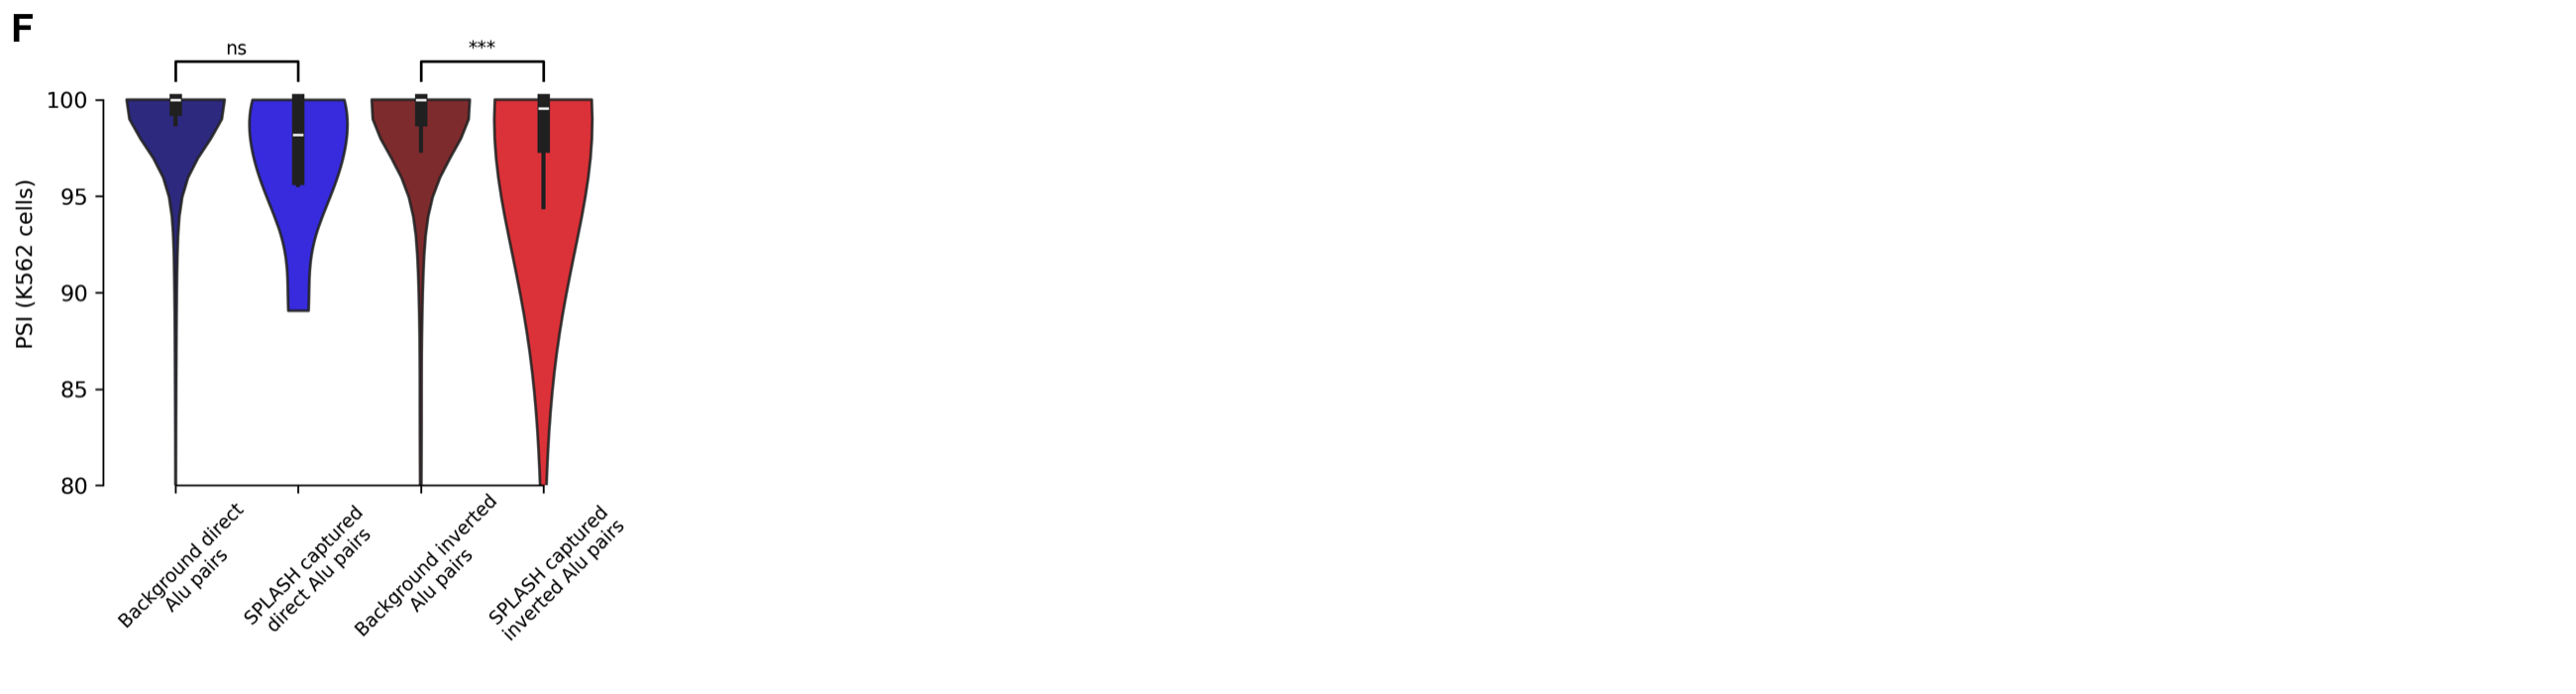

In [78]:
%%R -w 13 -h 3.5 --units in -r 200



bottom_row <- plot_grid(
  fig1F, 
  blank_plot,
  nrow = 1, 
  labels = c("F", ""),
  rel_widths = c(1, 3))

bottom_row

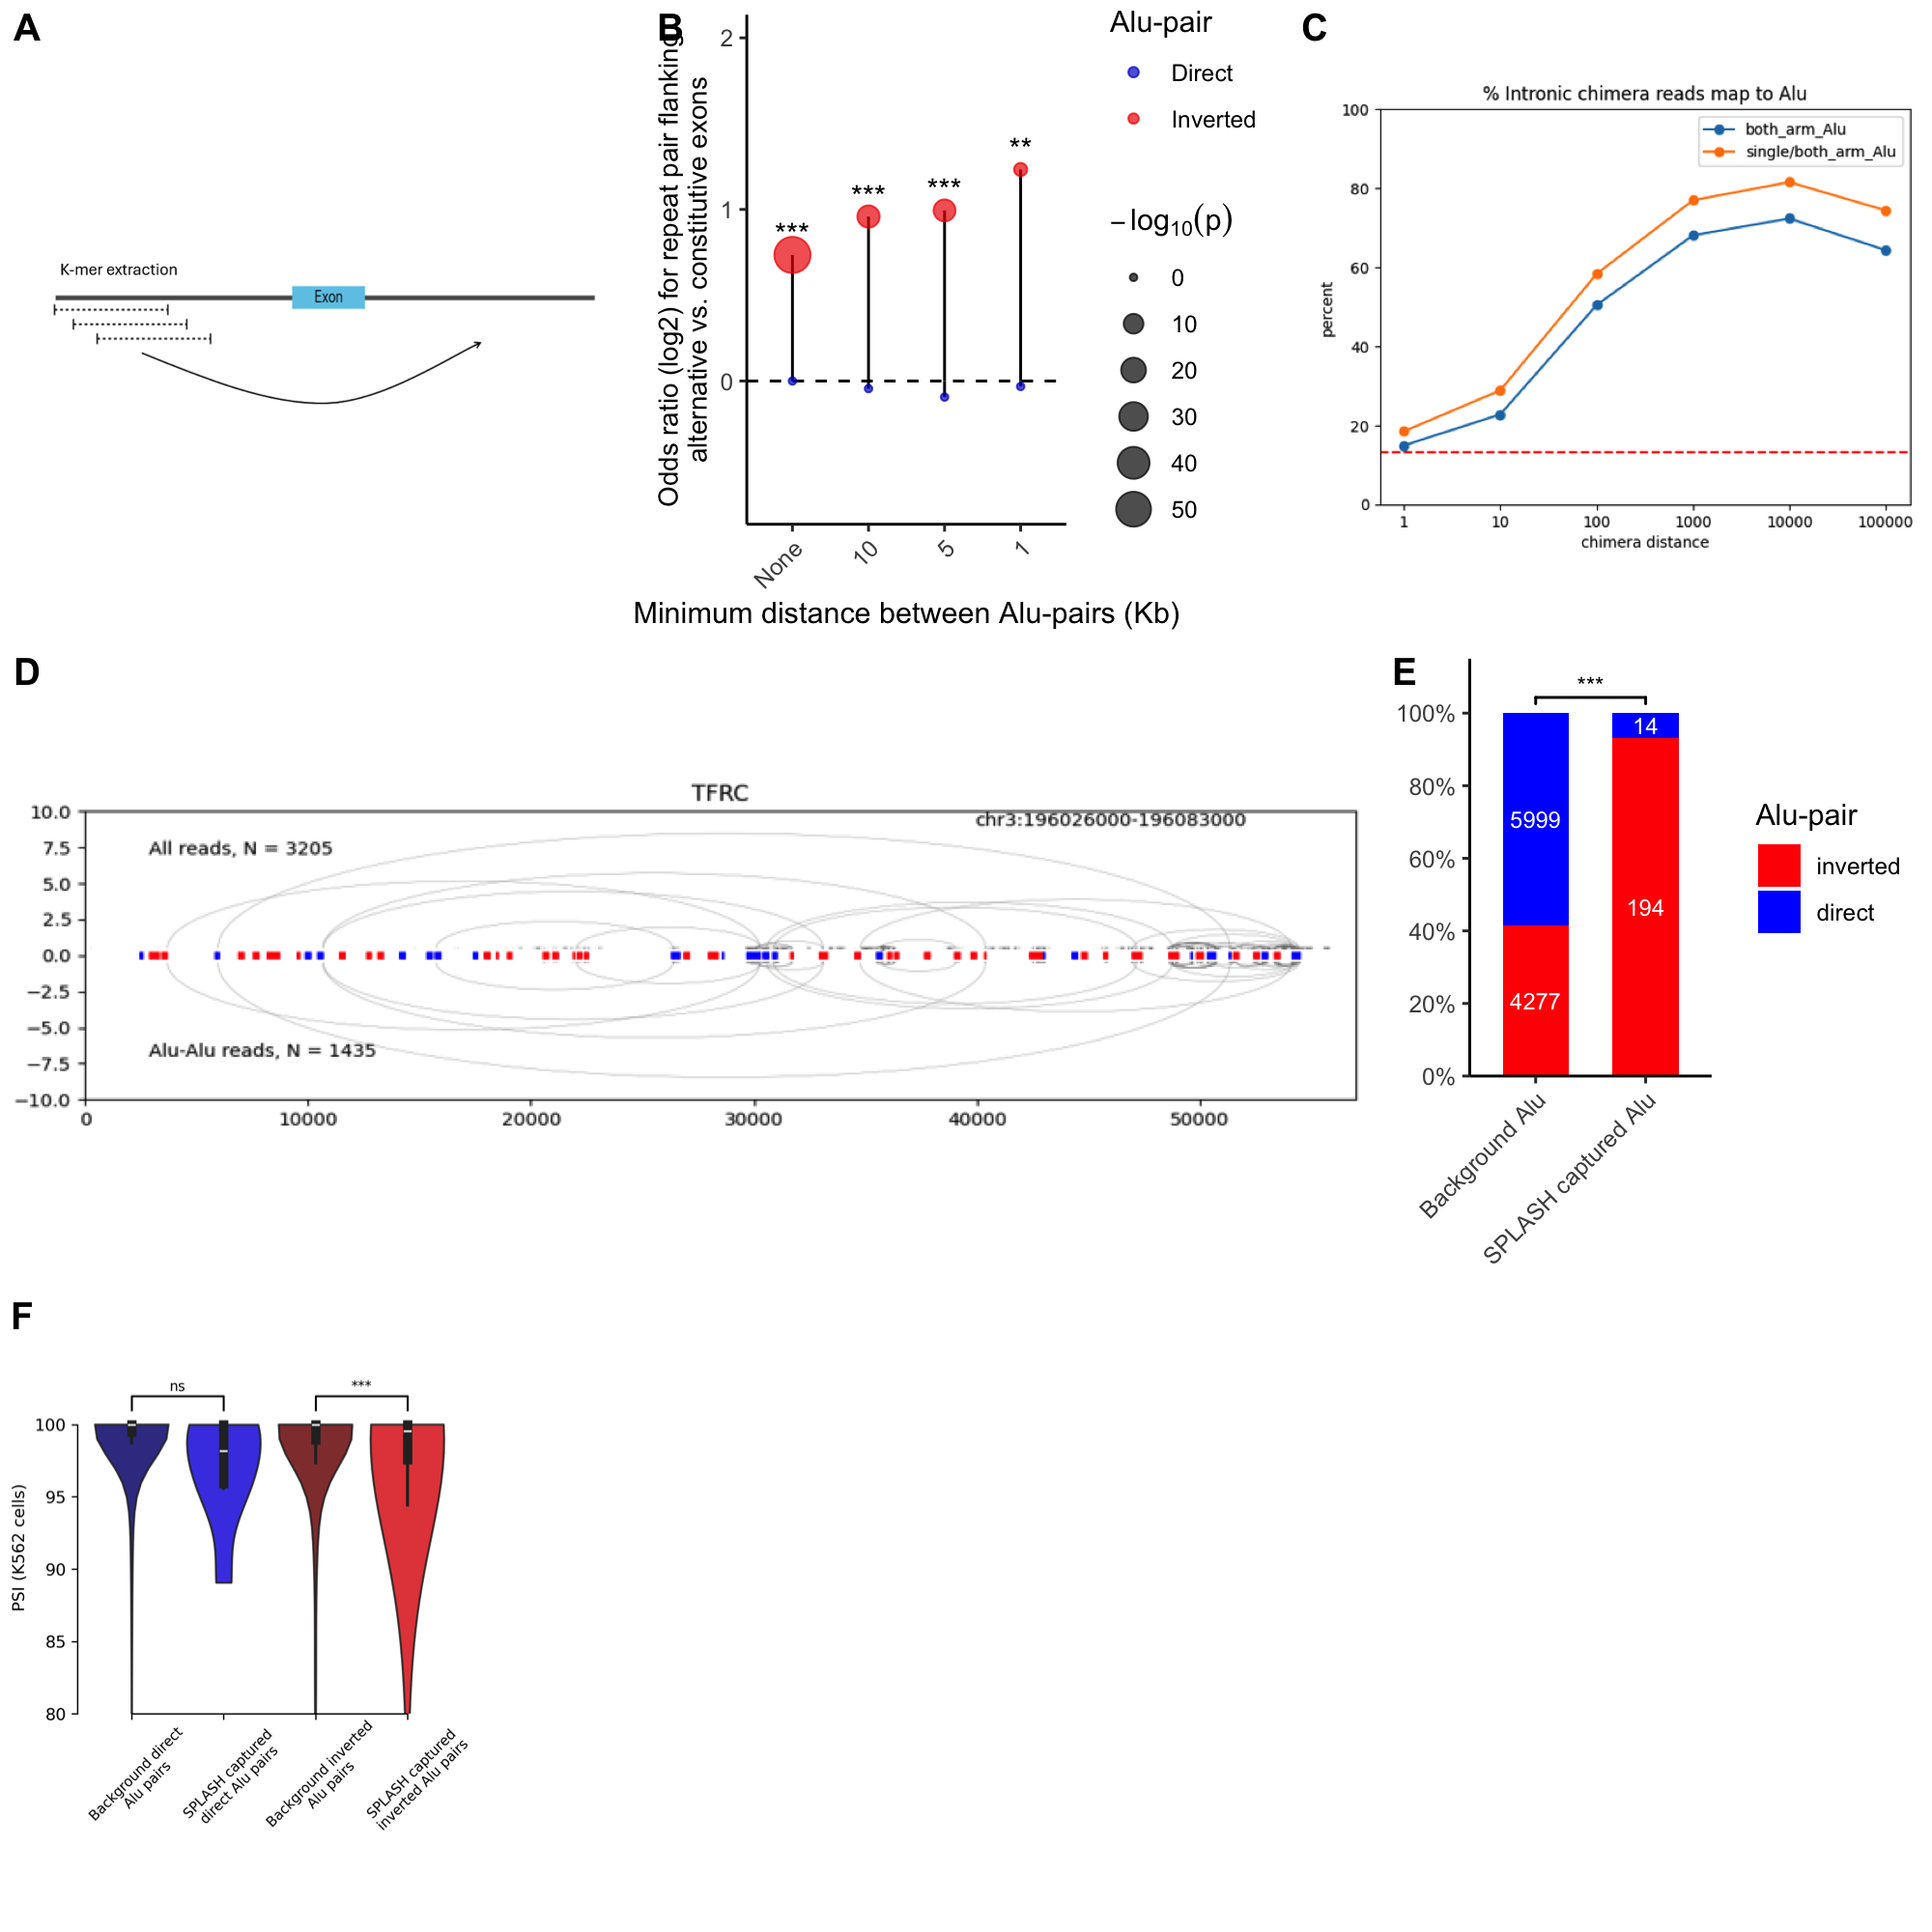

In [85]:
%%R -w 10 -h 10 --units in -r 200

Fig1 <- plot_grid(
  top_row, 
  middle_row, 
  bottom_row, 
  ncol = 1
)

print(Fig1)